In [12]:
import os
import re
import nibabel as nib
import numpy as np
from glob import glob

def dice_score(a, b):
    a = a > 0
    b = b > 0
    inter = np.count_nonzero(a & b)
    denom = np.count_nonzero(a) + np.count_nonzero(b)
    return (2.0 * inter) / (denom + 1e-6)

TEST_DIR = "/home/cuixing/MDP/Data_Predict/Test_Data"
PRED_ROOT = "/home/cuixing/MDP/Data_Predict/Predicted_Result/50_Predict"
GT_ROOT = "/nfs/turbo/coe-mreedsensitive/Processing/Chest/TotalSegmentator_FineTuning/SK"

case_ids = sorted({os.path.basename(f).split('_')[0] for f in glob(os.path.join(TEST_DIR, "*.nii.gz"))})

def map_pred_to_gt_name(fname):
    if fname == "labeled.nii.gz":
        return None
    m = re.fullmatch(r"rib_(\d+)\.nii\.gz", fname)
    if m:
        n = int(m.group(1))
        if 1 <= n <= 12:
            return f"rib_left_{n}.nii.gz"
        elif 13 <= n <= 24:
            return f"rib_right_{n-12}.nii.gz"
        else:
            return None
    return fname

all_dice = np.full((len(case_ids), 24), np.nan, dtype=np.float32)
i = 0
for cid in case_ids:
    pred_dir = os.path.join(PRED_ROOT, cid)
    gt_dir = os.path.join(GT_ROOT, cid, "segmentations")
    if not os.path.isdir(pred_dir) or not os.path.isdir(gt_dir):
        print(f"[SKIP] {cid}: pred_dir or gt_dir missing"); continue
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith(".nii.gz")])
    per_case = []
    for pf in pred_files:
        gt_name = map_pred_to_gt_name(pf)
        if gt_name is None:
            continue
        pred_path = os.path.join(pred_dir, pf)
        gt_path = os.path.join(gt_dir, gt_name)
        if not os.path.exists(gt_path):
            print(f"[MISS] {cid}: {gt_name}"); continue
        try:
            p = nib.load(pred_path).get_fdata()
            g = nib.load(gt_path).get_fdata()
        except Exception as e:
            print(f"[ERR] {cid}:{pf}: {e}"); continue
        if p.shape != g.shape:
            print(f"[SHAPE] {cid}:{pf} {p.shape} vs {g.shape}"); continue
        d = dice_score(g, p)
        per_case.append(d)
        #all_dice.append(d)
        print(f"{cid:>8} | {pf:<18} -> {d:.4f}")
    if per_case:
        print(f"[CASE AVG] {cid}: {np.mean(per_case):.4f} on {len(per_case)} structs")
        all_dice[i] = per_case
        i += 1
    else:
        print(f"[CASE AVG] {cid}: n/a (no matches)")
if all_dice:
    print(f"\n[OVERALL AVG] {np.mean(all_dice):.4f} over {len(all_dice)} structs")
else:
    print("\n[OVERALL AVG] n/a")


  CF5008 | rib_left_1.nii.gz  -> 0.8564
  CF5008 | rib_left_10.nii.gz -> 0.8725
  CF5008 | rib_left_11.nii.gz -> 0.8738
  CF5008 | rib_left_12.nii.gz -> 0.8710
  CF5008 | rib_left_2.nii.gz  -> 0.8930
  CF5008 | rib_left_3.nii.gz  -> 0.8846
  CF5008 | rib_left_4.nii.gz  -> 0.8863
  CF5008 | rib_left_5.nii.gz  -> 0.8803
  CF5008 | rib_left_6.nii.gz  -> 0.8860
  CF5008 | rib_left_7.nii.gz  -> 0.8908
  CF5008 | rib_left_8.nii.gz  -> 0.8639
  CF5008 | rib_left_9.nii.gz  -> 0.8893
  CF5008 | rib_right_1.nii.gz -> 0.8336
  CF5008 | rib_right_10.nii.gz -> 0.8887
  CF5008 | rib_right_11.nii.gz -> 0.8880
  CF5008 | rib_right_12.nii.gz -> 0.8519
  CF5008 | rib_right_2.nii.gz -> 0.8768
  CF5008 | rib_right_3.nii.gz -> 0.8797
  CF5008 | rib_right_4.nii.gz -> 0.8893
  CF5008 | rib_right_5.nii.gz -> 0.8983
  CF5008 | rib_right_6.nii.gz -> 0.9129
  CF5008 | rib_right_7.nii.gz -> 0.9101
  CF5008 | rib_right_8.nii.gz -> 0.8873
  CF5008 | rib_right_9.nii.gz -> 0.8763
[CASE AVG] CF5008: 0.8809 on 24 struc

  CF7011 | rib_left_3.nii.gz  -> 0.9403
  CF7011 | rib_left_4.nii.gz  -> 0.9587
  CF7011 | rib_left_5.nii.gz  -> 0.9548
  CF7011 | rib_left_6.nii.gz  -> 0.9515
  CF7011 | rib_left_7.nii.gz  -> 0.9507
  CF7011 | rib_left_8.nii.gz  -> 0.9526
  CF7011 | rib_left_9.nii.gz  -> 0.9560
  CF7011 | rib_right_1.nii.gz -> 0.9318
  CF7011 | rib_right_10.nii.gz -> 0.9585
  CF7011 | rib_right_11.nii.gz -> 0.9645
  CF7011 | rib_right_12.nii.gz -> 0.9651
  CF7011 | rib_right_2.nii.gz -> 0.9525
  CF7011 | rib_right_3.nii.gz -> 0.9385
  CF7011 | rib_right_4.nii.gz -> 0.9497
  CF7011 | rib_right_5.nii.gz -> 0.9480
  CF7011 | rib_right_6.nii.gz -> 0.9448
  CF7011 | rib_right_7.nii.gz -> 0.9439
  CF7011 | rib_right_8.nii.gz -> 0.9481
  CF7011 | rib_right_9.nii.gz -> 0.9531
[CASE AVG] CF7011: 0.9517 on 24 structs
  CM5115 | rib_left_1.nii.gz  -> 0.9339
  CM5115 | rib_left_10.nii.gz -> 0.9469
  CM5115 | rib_left_11.nii.gz -> 0.9546
  CM5115 | rib_left_12.nii.gz -> 0.9556
  CM5115 | rib_left_2.nii.gz  -> 0.94

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

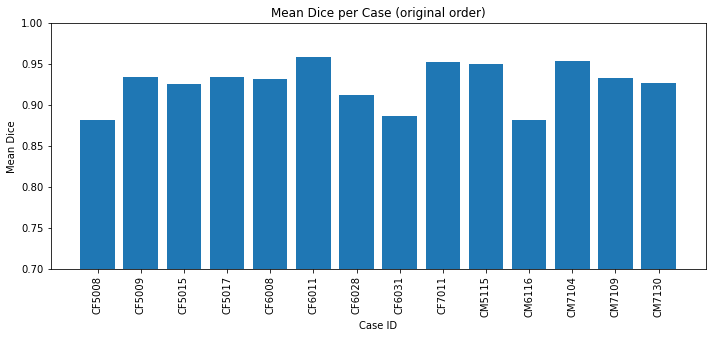

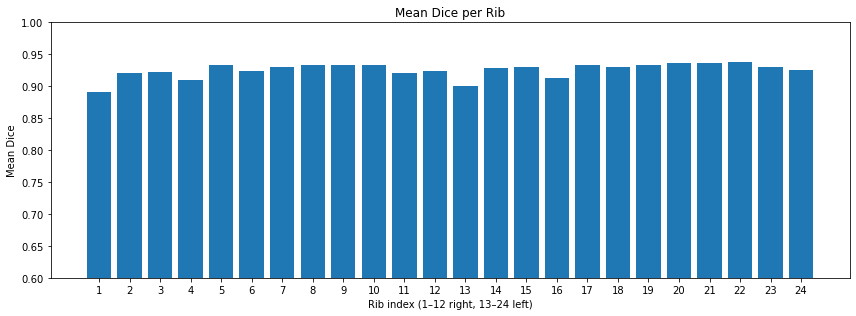

In [17]:
import numpy as np
import matplotlib.pyplot as plt

arr2d = np.asarray(all_dice, dtype=float)  # shape = (num_cases, 24)

# —— per patrinet（ignore NaN）——
per_case_means = np.nanmean(arr2d, axis=1)  # (num_cases,)
valid_case_mask = ~np.isnan(per_case_means)
cases_valid = [case_ids[i] for i in range(len(case_ids)) if valid_case_mask[i]]
case_vals = per_case_means[valid_case_mask]

# keep only cases with a valid mean, in original order
cases_shown = [case_ids[i] for i in range(len(case_ids)) if not np.isnan(per_case_means[i])]
vals_shown   = [per_case_means[i] for i in range(len(case_ids)) if not np.isnan(per_case_means[i])]

plt.figure(figsize=(max(10, 0.35*len(cases_shown)), 4.8))
plt.bar(range(len(cases_shown)), vals_shown)
plt.xticks(range(len(cases_shown)), cases_shown, rotation=90)
plt.ylim(0.7, 1)
plt.xlabel("Case ID")
plt.ylabel("Mean Dice")
plt.title("Mean Dice per Case (original order)")
plt.tight_layout()
plt.show()

# eahc ribs
per_rib_means = np.nanmean(arr2d, axis=0)  # (24,)
rib_idx = np.arange(1, 25)
valid_rib_mask = ~np.isnan(per_rib_means)
ribs_valid = rib_idx[valid_rib_mask]
rib_vals = per_rib_means[valid_rib_mask]

plt.figure(figsize=(max(8, 0.5*len(ribs_valid)), 4.5))
plt.bar([str(i) for i in ribs_valid], rib_vals)
plt.ylim(0.6, 1)
plt.xlabel("Rib index (1–12 right, 13–24 left)")
plt.ylabel("Mean Dice")
plt.title("Mean Dice per Rib")
plt.tight_layout()
plt.show()

PER_CASE_AVG = {case_ids[i]: (None if np.isnan(per_case_means[i]) else float(per_case_means[i]))
                for i in range(len(case_ids))}
RIB_AVG = {i+1: (None if np.isnan(per_rib_means[i]) else float(per_rib_means[i])) for i in range(24)}


rib  |  mean   std(pp)  IQR   CV(%)  n
  1  |  0.891     7.62  0.051    8.55  14
 13  |  0.900     6.77  0.048    7.52  14
  4  |  0.910     6.02  0.087    6.61  14
 16  |  0.913     4.92  0.084    5.40  14
  2  |  0.921     3.69  0.065    4.01  14
 12  |  0.924     3.48  0.066    3.77  14
  3  |  0.922     3.46  0.053    3.75  14
 11  |  0.922     3.28  0.054    3.55  14
 15  |  0.931     3.07  0.049    3.30  14
 24  |  0.926     3.05  0.048    3.29  14
 17  |  0.933     3.05  0.026    3.27  14
 14  |  0.928     2.96  0.040    3.19  14
  7  |  0.930     2.67  0.039    2.87  14
 18  |  0.930     2.57  0.025    2.77  14
  6  |  0.924     2.55  0.023    2.75  14
  9  |  0.933     2.49  0.018    2.67  14
 23  |  0.931     2.48  0.029    2.66  14
  5  |  0.933     2.47  0.024    2.65  14
 19  |  0.934     2.39  0.031    2.56  14
  8  |  0.933     2.31  0.030    2.48  14
 10  |  0.934     2.16  0.033    2.32  14
 20  |  0.936     1.80  0.017    1.93  14
 21  |  0.937     1.68  0.019    1.79

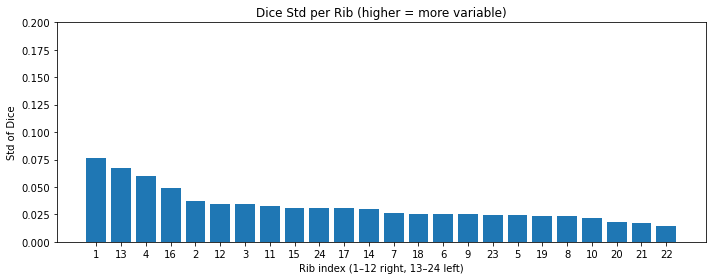

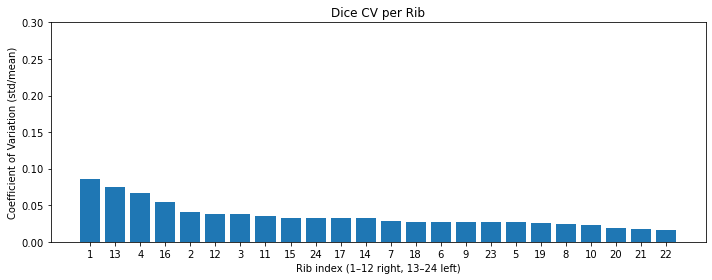

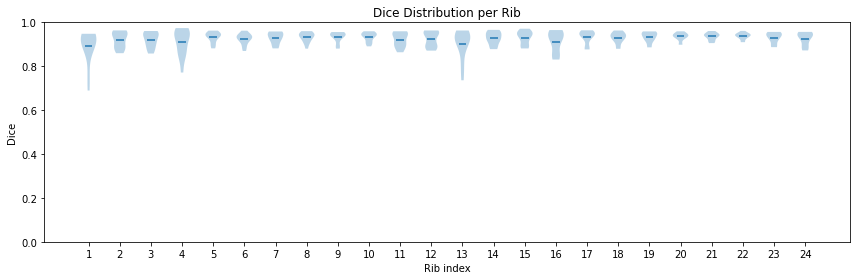

In [19]:
import numpy as np
import matplotlib.pyplot as plt

arr2d = np.asarray(all_dice, float)
per_rib_stats = []
for j in range(24):
    vals = arr2d[:, j]
    vals = vals[~np.isnan(vals)]
    if vals.size == 0:
        continue
    mean = float(np.mean(vals))
    std  = float(np.std(vals, ddof=1))       
    iqr  = float(np.percentile(vals, 75) - np.percentile(vals, 25))
    cv   = float(std/mean) if mean > 0 else np.nan
    per_rib_stats.append((j+1, mean, std, iqr, cv, vals.size))

# 
per_rib_stats.sort(key=lambda x: x[2], reverse=True)

print("rib  |  mean   std(pp)  IQR   CV(%)  n")
for rib, mean, std, iqr, cv, n in per_rib_stats:
    print(f"{rib:>3}  |  {mean:0.3f}   {std*100:6.2f}  {iqr:0.3f}  {cv*100:6.2f}  {n}")

# std 
ribs = [t[0] for t in per_rib_stats]
stds = [t[2] for t in per_rib_stats]
plt.figure(figsize=(10,4))
plt.bar([str(r) for r in ribs], stds)
plt.ylim(0, 0.2)  
plt.xlabel("Rib index (1–12 right, 13–24 left)")
plt.ylabel("Std of Dice")
plt.title("Dice Std per Rib (higher = more variable)")
plt.tight_layout()
plt.show()

#  CV（
cvs = [t[4] for t in per_rib_stats]
plt.figure(figsize=(10,4))
plt.bar([str(r) for r in ribs], cvs)
plt.ylim(0, 0.3)  
plt.xlabel("Rib index (1–12 right, 13–24 left)")
plt.ylabel("Coefficient of Variation (std/mean)")
plt.title("Dice CV per Rib")
plt.tight_layout()
plt.show()

# each dice socore distribute
data = [arr2d[:, j][~np.isnan(arr2d[:, j])] for j in range(24)]
plt.figure(figsize=(12,4))
plt.violinplot(data, showmeans=True, showextrema=False)
plt.xticks(range(1,25), [str(i) for i in range(1,25)])
plt.ylim(0,1)
plt.xlabel("Rib index")
plt.ylabel("Dice")
plt.title("Dice Distribution per Rib")
plt.tight_layout()
plt.show()
